Simulate the adversarial attacks on AI,


Team 1- CS Raksha and Sanjana Kulkarni,


Team Contribution :
- A deep understanding of Advesarial attacks
- Gaining knowledge on the different types of attacks and the different methodology of these attacks
- Made a code that was an inspiration for the following
- An organized documentation of what the following code is in a way that is easier to understand.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer: 1 input channel, 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # Second convolutional layer: 32 input channels, 64 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Fully connected layer: input size is 64*7*7 (after two 2x2 max poolings), output size is 128
        self.fc1 = nn.Linear(64*7*7, 128)
        # Fully connected layer: input size is 128, output size is 10 (for 10 classes)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply first convolutional layer followed by ReLU activation
        x = F.relu(self.conv1(x))
        # Apply 2x2 max pooling
        x = F.max_pool2d(x, 2)
        # Apply second convolutional layer followed by ReLU activation
        x = F.relu(self.conv2(x))
        # Apply 2x2 max pooling
        x = F.max_pool2d(x, 2)
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 64*7*7)
        # Apply first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        # Apply second fully connected layer
        x = self.fc2(x)
        return x


# Create an instance of the model
model = SimpleCNN()
# Load the pretrained model weights
model.load_state_dict(torch.load('pretrained_mnist_cnn.pth'))
# Set the model to evaluation mode
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# Load the MNIST dataset with transformation to tensor
transform = transforms.Compose([transforms.ToTensor()])
# Load test dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
# Create a data loader for the test dataset
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

In [ ]:
# Define the C&W adversarial attack function
def cw_attack(model, images, labels, targeted=False, target_label=1, c=1e-3, lr=0.001, num_iterations=500):
    # Clone and detach the input images, and set requires_grad to True
    images = images.clone().detach().requires_grad_(True)
    # If targeted attack, set all labels to the target label
    if targeted:
        target_labels = torch.full(labels.shape, target_label, dtype=torch.long)
    else:
        target_labels = labels

    # Use Adam optimizer to adjust the images
    optimizer = torch.optim.Adam([images], lr=lr)
    # Save a copy of the original images
    original_images = images.clone().detach()

    for i in range(num_iterations):
        # Zero the gradients of the optimizer
        optimizer.zero_grad()
        # Get the model's outputs for the perturbed images
        outputs = model(images)
        # Compute the loss: combination of MSE loss and negative Cross-Entropy loss
        loss = c * F.mse_loss(images, original_images) - F.cross_entropy(outputs, target_labels)
        # Backpropagate the loss
        loss.backward()
        # Update the images
        optimizer.step()
        # Clamp the image values to be between 0 and 1
        images.data = torch.clamp(images.data, 0, 1)

        # Print loss every 100 iterations
        if i % 100 == 0:
            print(f'Iteration {i}/{num_iterations}, Loss: {loss.item()}')

    # Return the adversarial images
    adversarial_images = images.detach()
    return adversarial_images

In [ ]:
def show_images_and_predictions(model, original, adversarial, perturbation):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    # Original image
    axs[0].imshow(original.squeeze(), cmap='gray')
    axs[0].set_title(f'Original\nPrediction: {model(original).argmax(dim=1).item()}')

    # Adversarial image
    axs[1].imshow(adversarial.squeeze(), cmap='gray')
    axs[1].set_title(f'Adversarial\nPrediction: {model(adversarial).argmax(dim=1).item()}')

    # Perturbation
    axs[2].imshow(perturbation.squeeze(), cmap='gray')
    axs[2].set_title('Perturbation')

    # Remove axis ticks
    for ax in axs:
        ax.axis('off')
    # Show the plot
    plt.show()

In [ ]:
# Get a batch of test images and labels
images, labels = next(iter(test_loader))

# Generate adversarial images using the C&W attack
adversarial_images = cw_attack(model, images, labels, targeted=False)

# Calculate the perturbation by subtracting the original images from the adversarial images
perturbation = adversarial_images - images

Iteration 0/500, Loss: -3.576278118089249e-07
Iteration 100/500, Loss: -0.15107965469360352
Iteration 200/500, Loss: -13.507684707641602
Iteration 300/500, Loss: -23.85543441772461
Iteration 400/500, Loss: -31.64390754699707


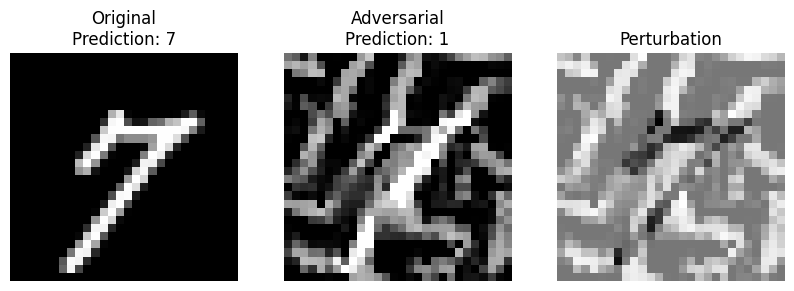

In [ ]:
# Show images and predictions
show_images_and_predictions(model, images, adversarial_images, perturbation)

**Conclusion:**

- The C&W attack successfully altered an image, changing its classification from '7' to '1'.
- Perturbations introduced are minimal and not noticeable to the human eye.
- These subtle changes exploit the AI model’s weaknesses.
- The experiment highlights the need for better defenses against adversarial attacks.